## Data Analysis

In [1]:
# imports
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from functions import clean_data

import nltk
from nltk import pos_tag
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
#nltk.download('vader_lexicon')
from textblob import TextBlob

%matplotlib inline

In [2]:
df = pd.read_csv('/Users/gonzandrobles/Desktop/Python/ipynb_notebooks/other_projects/nlp_projects/capstone_project/reviews.csv')
df = clean_data(df)

In [3]:
df.shape

(221, 5)

In [4]:
df.head()

,username,location,date,rating,content
0,Abdul Rafay K.,"Chapel Hill, NC",2019-12-15,5.0,I spent about two hours here in order to focus...
1,Jennifer L.,"Seattle, WA",2019-01-27,4.0,I love the vibe here! It gets pretty busy espe...
2,Stacy A.,"Federal Way, WA",2019-11-05,3.0,Probably I came here on the wrong day because ...
3,Yoni C.,"Issaquah, WA",2019-11-03,5.0,It was after visiting Tacoma Art Museum and ni...
4,Keri F.,"Seattle, WA",2019-08-18,5.0,Wonderful cafe and roasterie in Tacoma. Came h...


In [5]:
# the date is an object so we need to convert it to datetime
df['date'] = pd.to_datetime(df['date'])

In [6]:
# checking for the data types of df
df.dtypes

username            object
location            object
date        datetime64[ns]
rating             float64
content             object
dtype: object

In [7]:
df.nunique()

username    218
location     82
date        214
rating        5
content     221
dtype: int64

In [8]:
df.duplicated().sum()

0

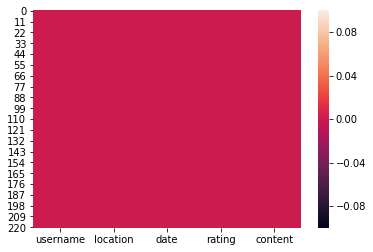

In [9]:
sns.heatmap(df.isnull());

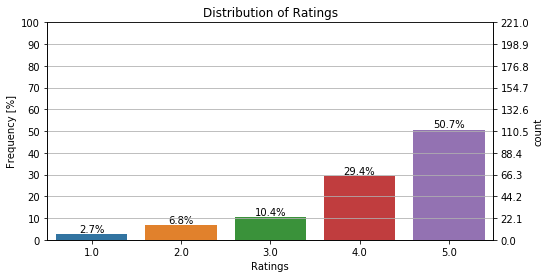

In [10]:
# checking for the ratio of rating
# event column dimensions
ncount = df['rating'].shape[0]

# setting figure size to 8 by 4
plt.figure(figsize=(8,4))
# countplot where x is 'event' and the data is 'transcript'
ax = sns.countplot(x="rating", data=df)
# setting the title of the chart
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')

# Make twin axis
ax2=ax.twinx()

# switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

# frrequency label
ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
    

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

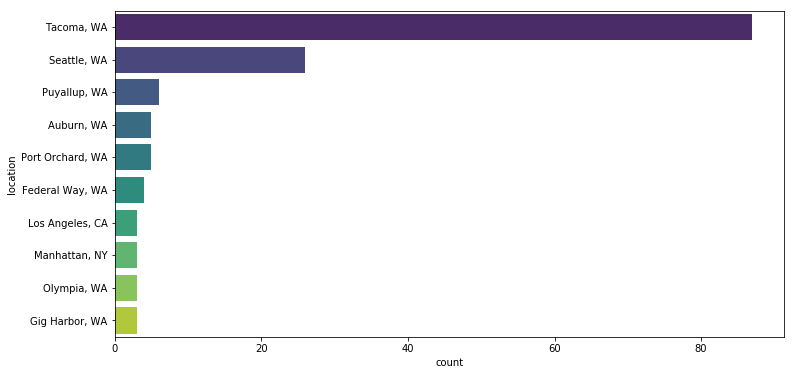

In [11]:
# Top 10 cities where reviews come from
plt.figure(figsize=(12, 6))
time_count = sns.countplot(y=df['location'], palette='viridis', order=df['location'].value_counts()[:10].index)
time_count;

In [12]:
df["location"].value_counts(normalize = True)[:10]

Tacoma, WA          0.393665
Seattle, WA         0.117647
Puyallup, WA        0.027149
Auburn, WA          0.022624
Port Orchard, WA    0.022624
Federal Way, WA     0.018100
Los Angeles, CA     0.013575
Manhattan, NY       0.013575
Olympia, WA         0.013575
Gig Harbor, WA      0.013575
Name: location, dtype: float64

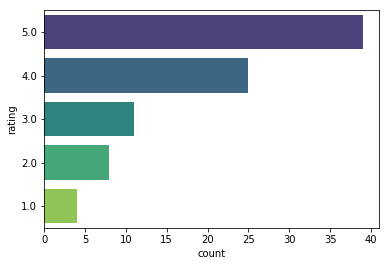

In [13]:
# counts of reviews in Tacoma
tacoma_rating = df.query('location == "Tacoma, WA"')['rating']
sns.countplot(y=tacoma_rating, palette='viridis', order=tacoma_rating.value_counts().index);

Since the coffee shop is located in Tacoma, it makes a lot of sense that most of the reviews come from the same location and most of those reviews are either 4 or 5 stars.

## Feature Extraction

In [14]:
# create two new columns for year and month to check reviews per year and month
df_copy = df.copy()
df_copy['reviews_per_year'] = df['date'].dt.year
df_copy['reviews_per_month'] = df['date'].dt.month

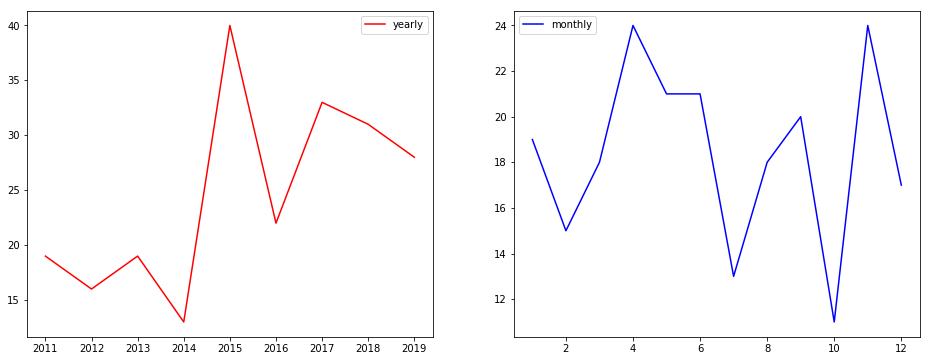

In [15]:
# linear plot for yearly and monthly reviews
fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.lineplot(data=df_copy['reviews_per_year'].value_counts(), color="red", label="yearly", ax=ax[0])
sns.lineplot(data=df_copy['reviews_per_month'].value_counts(), color="blue", label="monthly", ax=ax[1]);

In [16]:
per_year = df_copy['reviews_per_year'].value_counts().max()
per_month = df_copy['reviews_per_month'].value_counts().max()
print(f'''2015 was the year with most reviews: {per_year}, 
while April and November are the months with more reviews: {per_month}''')

2015 was the year with most reviews: 40, 
while April and November are the months with more reviews: 24


In [17]:
# create two new columns to analyze ratings by number of words and punctuations
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df_copy['body_len'] = df['content'].apply(lambda x: len(x) - x.count(" "))
df_copy['punct%'] = df['content'].apply(lambda x: count_punct(x))

In [18]:
df_copy.head()

,username,location,date,rating,content,reviews_per_year,reviews_per_month,body_len,punct%
0,Abdul Rafay K.,"Chapel Hill, NC",2019-12-15,5.0,I spent about two hours here in order to focus...,2019,12,225,2.7
1,Jennifer L.,"Seattle, WA",2019-01-27,4.0,I love the vibe here! It gets pretty busy espe...,2019,1,530,2.8
2,Stacy A.,"Federal Way, WA",2019-11-05,3.0,Probably I came here on the wrong day because ...,2019,11,293,2.0
3,Yoni C.,"Issaquah, WA",2019-11-03,5.0,It was after visiting Tacoma Art Museum and ni...,2019,11,219,1.8
4,Keri F.,"Seattle, WA",2019-08-18,5.0,Wonderful cafe and roasterie in Tacoma. Came h...,2019,8,211,4.3


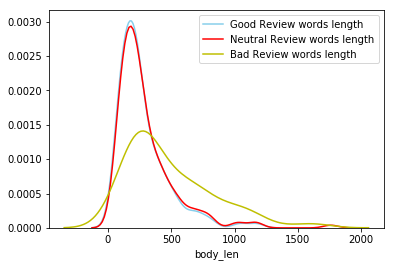

In [19]:
# distribution of number of words by rating ( 5 stars, 4 stars, less than 4)
good_rating = df_copy.query('rating == 5')['body_len']
neutral_rating = df_copy.query('rating >= 4')['body_len']
bad_rating = df_copy.query('rating < 4')['body_len']

sns.distplot(good_rating , color="skyblue", label="Good Review words length", hist=False)
sns.distplot(neutral_rating , color="red", label="Neutral Review words length", hist=False)
sns.distplot(bad_rating , color="y", label="Bad Review words length", hist=False);

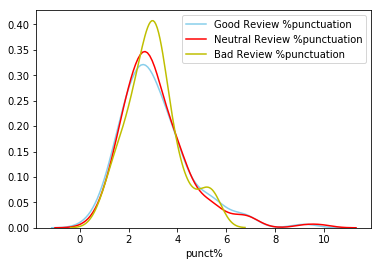

In [20]:
# distribution of number of words by rating ( 5 stars, 4 stars, less than 4)
good_rating = df_copy.query('rating == 5')['punct%']
neutral_rating = df_copy.query('rating >= 4')['punct%']
bad_rating = df_copy.query('rating < 4')['punct%']

sns.distplot(good_rating , color="skyblue", label="Good Review %punctuation", hist=False)
sns.distplot(neutral_rating , color="red", label="Neutral Review %punctuation", hist=False)
sns.distplot(bad_rating , color="y", label="Bad Review %punctuation", hist=False);

We can see that bad reviews tend to have more words than good or neutral reviews. I guess that's normal since bad reviews are usually more detailed than good reviews.

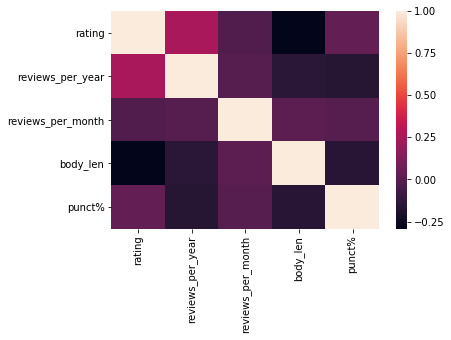

In [21]:
# checking for correlation between variables
sns.heatmap(df_copy.corr());

We can't see any clear correlations of what customers have when writting reviews.

___

In [22]:
df.head()

,username,location,date,rating,content
0,Abdul Rafay K.,"Chapel Hill, NC",2019-12-15,5.0,I spent about two hours here in order to focus...
1,Jennifer L.,"Seattle, WA",2019-01-27,4.0,I love the vibe here! It gets pretty busy espe...
2,Stacy A.,"Federal Way, WA",2019-11-05,3.0,Probably I came here on the wrong day because ...
3,Yoni C.,"Issaquah, WA",2019-11-03,5.0,It was after visiting Tacoma Art Museum and ni...
4,Keri F.,"Seattle, WA",2019-08-18,5.0,Wonderful cafe and roasterie in Tacoma. Came h...


## Clean Data

In [23]:
# return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [24]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and removes puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df["clean_content"] = df["content"].apply(lambda x: clean_text(x))

Let's drop unnecessary columns

In [25]:
df.drop(columns=['username', 'location', 'date', 'content'], inplace=True)

## Sentiment Analysis

In [26]:
# add sentiment anaylsis columns
sia = SentimentIntensityAnalyzer()
df["sentiments"] = df["clean_content"].apply(lambda x: sia.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

In [27]:
# add number of characters column
df["nb_chars"] = df["clean_content"].apply(lambda x: len(x))

# add number of words column
df["nb_words"] = df["clean_content"].apply(lambda x: len(x.split(" ")))

In [28]:
df.head()

,rating,clean_content,neg,neu,pos,compound,nb_chars,nb_words
0,5.0,spend two hour order focus work order latte so...,0.000,0.661,0.339,0.8832,168,26
1,4.0,love vibe get pretty busy especially student r...,0.034,0.701,0.265,0.9472,393,61
2,3.0,probably come wrong day go homework wifi work ...,0.223,0.485,0.293,0.6361,187,30
3,5.0,visit tacoma art museum nice stop really like ...,0.051,0.346,0.603,0.9716,163,25
4,5.0,wonderful cafe roasterie tacoma come study caf...,0.000,0.455,0.545,0.9705,173,24


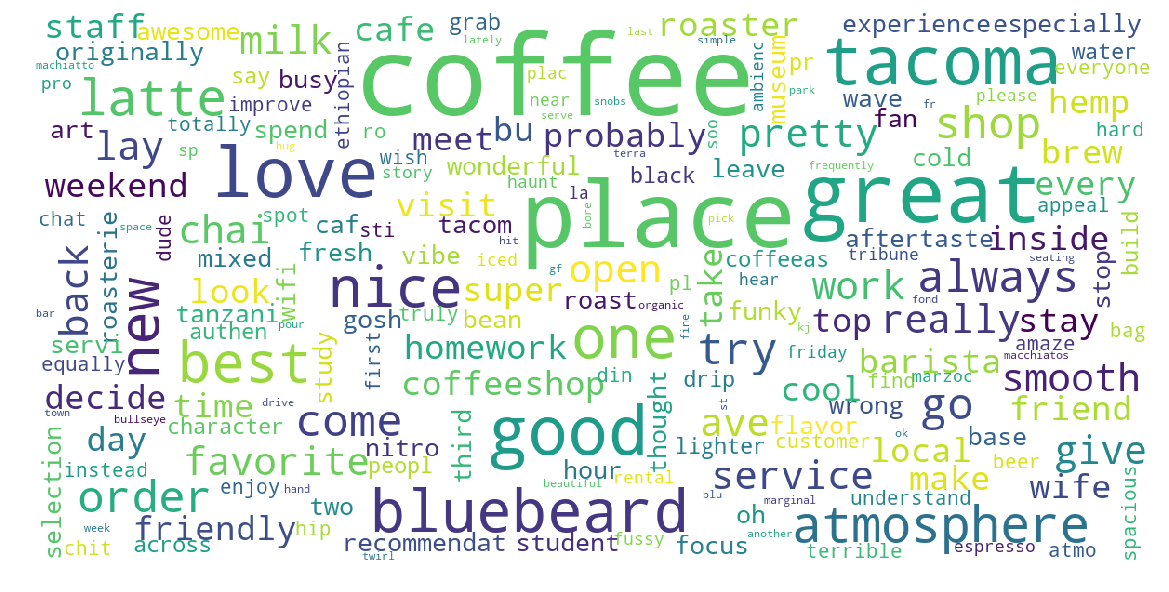

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df["clean_content"])

In [30]:
# highest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("pos", ascending = False)[["clean_content", "pos"]].head(10)

,clean_content,pos
152,latte delicious love space barista really swee...,0.782
49,nice people awesome wave coffee friendly location,0.716
168,best best best tacoma atmosphere coffee staff ...,0.714
145,coffee amaze baristas super nice location perf...,0.658
16,great place great character build great staff ...,0.640
103,husband stop see high review wonderful love at...,0.632
157,great space good coffee friendly fast staff ma...,0.632
144,best coffee town lot seat great wi-fi nice loc...,0.628
23,dude best coffee ever truly make love wish sti...,0.609
3,visit tacoma art museum nice stop really like ...,0.603


In [31]:
# lowest negative sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("neg", ascending = False)[["clean_content", "neg"]].head(10)

,clean_content,neg
214,basic mocha good smooth bitterness could bite ...,0.353
165,really great coffee terrible hipster service q...,0.331
88,place awesome tinder date slowly go shit hell ...,0.252
210,go back nothing like proper latte middle day,0.232
81,i'm vegan totally space ask sub milk mind pay ...,0.224
2,probably come wrong day go homework wifi work ...,0.223
169,since go caffe dei orange chocolate coffee dri...,0.221
40,place suck offer quality coffee reasonable pri...,0.213
203,wife coffee snobs bluebeard one best best town...,0.211
155,yummy coffee nice open space great person need...,0.201


Final summarized counts : [51, 131, 39]

 Pie Representation 
-------------------


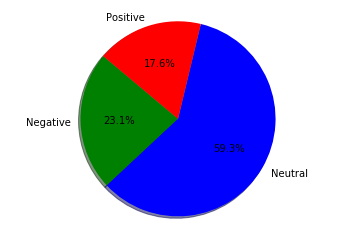

In [32]:
# Pie chart of sentiment Polarity
#Categorize Polarity into Positive, Neutral or Negative
labels = ["Negative", "Neutral", "Positive"]
#Initialize count array
values =[0,0,0]

#Categorize each review
for review in df['clean_content']:
    sentiment = TextBlob(review)
    
    #Custom formula to convert polarity 
    # 0 = (Negative) 1 = (Neutral) 2=(Positive)
    polarity = round(( sentiment.polarity + 1 ) * 3 ) % 3
    
    #add the summary array
    values[polarity] = values[polarity] + 1
    
print("Final summarized counts :", values)

#Set colors by label
colors=["Green","Blue","Red"]

print("\n Pie Representation \n-------------------")
#Plot a pie chart
plt.pie(values, labels=labels, colors=colors, \
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [33]:
# Sentiments by Review
print('{:40} : {:10} : {:10}'.format("Review", "Polarity", "Subjectivity") )

for review in df['clean_content']:
    #Find sentiment of a review
    sentiment = TextBlob(review)
    #Print individual sentiments
    print('{:40} :   {: 01.2f}    :   {:01.2f}'.format(review[:40]\
                , sentiment.polarity, sentiment.subjectivity) )

Review                                   : Polarity   : Subjectivity
spend two hour order focus work order la :    0.38    :   0.77
love vibe get pretty busy especially stu :    0.19    :   0.50
probably come wrong day go homework wifi :    0.06    :   0.63
visit tacoma art museum nice stop really :    0.34    :   0.55
wonderful cafe roasterie tacoma come stu :    0.79    :   0.80
great third wave coffeeshop probably one :    0.38    :   0.62
great service atmosphere selection roast :    0.46    :   0.56
awesome coffee baristas really nice stay :    0.59    :   0.90
mixed thought originally come base recom :   -0.01    :   0.45
new tacoma look good coffee shop order t :    0.25    :   0.48
fan flavor coffee leave funky aftertaste :    0.43    :   0.63
oh gosh great experience try order nitro :    0.37    :   0.70
one top favorite place go tacoma fresh l :    0.20    :   0.57
always try new local coffee grab black d :    0.26    :   0.58
great coffeeas barista across water say  :    0.2

coffee bad really anything fantastic eit :    0.23    :   0.52
fav earth baristas higher thou attitude  :    0.47    :   0.55
love place good coffee ambiance star out :   -0.03    :   0.56
go catch friend enjoy atmosphere love pl :    0.21    :   0.45
great coffee nothing super fancy ton fla :    0.71    :   0.81
cool little spot ave plus saw place grea :    0.26    :   0.52
small menu see alot people come study ha :   -0.03    :   0.42
let begin say tea snob little knowledge  :    0.20    :   0.51
aroma walk please dont like drink coffee :    0.80    :   0.75
always good experience come definitely o :    0.40    :   0.80
regard coffee bean go seriously bluebear :    0.33    :   0.57
good average coffee roomy area table ins :    0.53    :   0.58
far favorite coffee house/roaster tacoma :    0.36    :   0.57
favorite coffee tacoma shop clean simply :    0.15    :   0.56
best coffee town lot seat great wi-fi ni :    0.80    :   0.70
coffee amaze baristas super nice locatio :    0.55    :

In [34]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [35]:
# Most common words
common_words = get_top_n_words(df['clean_content'], 20)
for word, freq in common_words:
    print(word, freq)

coffee 338
place 141
great 113
good 106
like 90
get 81
bluebeard 71
one 71
go 70
shop 70
tacoma 69
make 64
latte 63
friendly 57
really 55
come 53
nice 52
love 50
drink 48
work 47
